# COGS 118A: Supervised Machine Learning Algorithms
## Logistic Regression

I use this notebook as a starting point to code the answers to the coding questions of my assignment, which demonstrates using the Iris dataset to conduct logistic regression with gradient descent to determine appropriate decision boundary of the classification of whether a flower was a Setosa or Virginica. The training loss curve is also plotted as the number of iterations increase.

In [201]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

### Load the modified Iris dataset

In [202]:
# Iris dataset.
iris = datasets.load_iris()     # Load Iris dataset.

X = iris.data                   # The shape of X is (150, 4), which means
                                # there are 150 data points, each data point
                                # has 4 features.

# Here for convenience, we divide the 3 kinds of flowers into 2 groups: 
#     Y = 0 (or False):  Setosa (original value 0) / Versicolor (original value 1)
#     Y = 1 (or True):   Virginica (original value 2)

# Thus we use (iris.target > 1.5) to divide the targets into 2 groups. 
# This line of code will assign:
#    Y[i] = True  (which is equivalent to 1) if iris.target[k]  > 1.5 (Virginica)
#    Y[i] = False (which is equivalent to 0) if iris.target[k] <= 1.5 (Setosa / Versicolor)

Y = (iris.target > 1.5).reshape(-1,1).astype(np.float) # The shape of Y is (150, 1), which means 
                                # there are 150 data points, each data point
                                # has 1 target value. 
Y[Y==0] = -1

X_and_Y = np.hstack((X, Y))     # Stack them together for shuffling.
np.random.seed(1)               # Set the random seed.
np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array

print(X.shape)
print(Y.shape)
print(X_and_Y)               # The result should be always: [ 5.8  4.   1.2  0.2  -1 ]

(150, 4)
(150, 1)
[[ 5.8  4.   1.2  0.2 -1. ]
 [ 5.1  2.5  3.   1.1 -1. ]
 [ 6.6  3.   4.4  1.4 -1. ]
 [ 5.4  3.9  1.3  0.4 -1. ]
 [ 7.9  3.8  6.4  2.   1. ]
 [ 6.3  3.3  4.7  1.6 -1. ]
 [ 6.9  3.1  5.1  2.3  1. ]
 [ 5.1  3.8  1.9  0.4 -1. ]
 [ 4.7  3.2  1.6  0.2 -1. ]
 [ 6.9  3.2  5.7  2.3  1. ]
 [ 5.6  2.7  4.2  1.3 -1. ]
 [ 5.4  3.9  1.7  0.4 -1. ]
 [ 7.1  3.   5.9  2.1  1. ]
 [ 6.4  3.2  4.5  1.5 -1. ]
 [ 6.   2.9  4.5  1.5 -1. ]
 [ 4.4  3.2  1.3  0.2 -1. ]
 [ 5.8  2.6  4.   1.2 -1. ]
 [ 5.6  3.   4.5  1.5 -1. ]
 [ 5.4  3.4  1.5  0.4 -1. ]
 [ 5.   3.2  1.2  0.2 -1. ]
 [ 5.5  2.6  4.4  1.2 -1. ]
 [ 5.4  3.   4.5  1.5 -1. ]
 [ 6.7  3.   5.   1.7 -1. ]
 [ 5.   3.5  1.3  0.3 -1. ]
 [ 7.2  3.2  6.   1.8  1. ]
 [ 5.7  2.8  4.1  1.3 -1. ]
 [ 5.5  4.2  1.4  0.2 -1. ]
 [ 5.1  3.8  1.5  0.3 -1. ]
 [ 6.1  2.8  4.7  1.2 -1. ]
 [ 6.3  2.5  5.   1.9  1. ]
 [ 6.1  3.   4.6  1.4 -1. ]
 [ 7.7  3.   6.1  2.3  1. ]
 [ 5.6  2.5  3.9  1.1 -1. ]
 [ 6.4  2.8  5.6  2.1  1. ]
 [ 5.8  2.8  5.1  2.4  1. ]
 [

In [203]:
# Divide the data points into training set and test set.
X_shuffled = X_and_Y[:,:4]
Y_shuffled = X_and_Y[:,4]


X_train = X_shuffled[:100][:,[3,1]] # Shape: (100,2)
X_train = np.delete(X_train, 42, axis=0) # Remove a point for separability.
Y_train = Y_shuffled[:100]          # Shape: (100,)
Y_train = np.delete(Y_train, 42, axis=0) # Remove a point for separability.
X_test = X_shuffled[100:][:,[3,1]]  # Shape: (50,2)
Y_test = Y_shuffled[100:]           # Shape: (50,)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(99, 2)
(99,)
(50, 2)
(50,)


### Visualization

In [204]:
def vis(X, Y, W=None, b=None):
    indices_neg1 = (Y == -1).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1], 
                c='blue', label='class -1')
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1], 
                c='red', label='class 1')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')
    
    if W is not None:
        # w0x0+w1x1+b=0 => x1=-w0x0/w1-b/w1
        w0 = W[0]
        w1 = W[1]
        temp = -w1*np.array([X[:,1].min(), X[:,1].max()])/w0-b/w0
        x0_min = max(temp.min(), X[:,0].min())
        x0_max = min(temp.max(), X[:,1].max())
        x0 = np.linspace(x0_min,x0_max,100)
        x1 = -w0*x0/w1-b/w1
        plt.plot(x0,x1,color='black')

    plt.show()

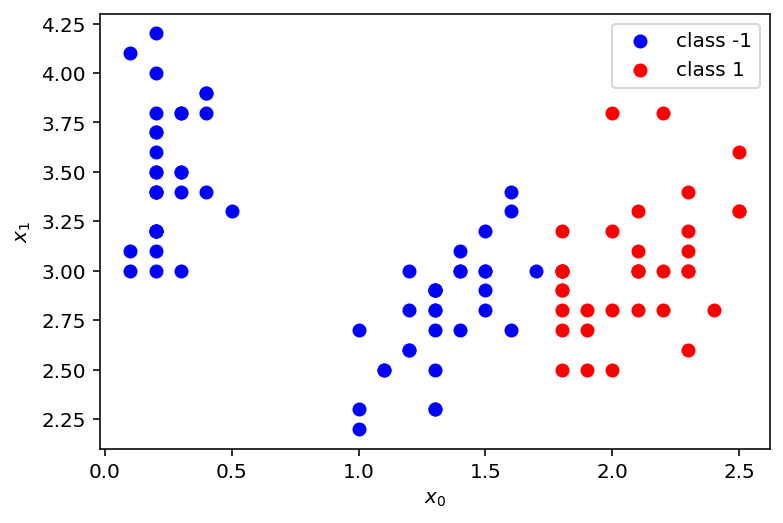

In [205]:
# Visualize training set.
vis(X_train, Y_train)

### Logistic Regression Using Gradient Descent

In this problem, we would like to use the gradient descent to calculate the parameters $\mathbf{w},b$ for a logistic regression model.
If we have the loss function $\mathcal{L}(\mathbf{w},b)$, then a typical gradient descent algorithm contains the following steps:

**Step 1**. Initialize the parameters $\mathbf{w}$, $b$.

for i = 1 to #iterations:

- **Step 2**. Compute the partial derivatives $\frac{\partial \mathcal{L}(\mathbf{w},b)}{\partial \mathbf{w}}$, $\frac{\partial \mathcal{L}(\mathbf{w},b)}{\partial b}$.

- **Step 3**. Update the parameters 
$$\mathbf{w} \leftarrow \mathbf{w} - \eta \frac{\partial \mathcal{L}(\mathbf{w}, b)}{\partial \mathbf{w}}, \quad\quad b \leftarrow b - \eta \frac{\partial \mathcal{L}(\mathbf{w},b)}{\partial b}$$
where $\eta$ is the learning rate.

Note that in the code, we use `W` and `b` to represent the weight vector $\mathbf{w}$ and bias scalar $b$.

In [206]:
# Sigmoid function: sigmoid(z) = 1/(1 + e^(-z))
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

In [207]:
# Judge function: 1(a != b).
def judge(a, b):
    if a != b:
        return 1
    else:
        return 0
    
# Logistic regression classifier.
def f_logistic(x, W, b):
    # x should be a 2-dimensional vector, 
    # W should be a 2-dimensional vector,
    # b should be a scalar.
    # you should return a scalar which is -1 or 1.
    
    if sigmoid(np.dot(W, x)+b) >= 0.5:
        return 1
    else:
        return -1
    
# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, W, b):
    sum_error = 0
    for (xi, yi) in zip(X, Y):
        # Hint: Use judge() and f_logistic()
        sum_error = sum_error + judge(yi, f_logistic(xi, W, b))
    
    return sum_error / len(X)

In [208]:
# Gradient of L(W, b) with respect to W and b.
def grad_L_W_b(X, Y, W, b):
    
    p= sigmoid(Y*(np.dot(X,W)+b))

    grad_W = -np.dot(X.T, (np.ones_like(Y) - p)*Y)
    grad_b = -np.dot(np.ones_like(Y).T, (np.ones_like(Y) - p)*Y)
    
    return grad_W, grad_b

In [209]:
# Loss L(W, b).
def L_W_b(X, Y, W, b):
    # You should return a scalar.
    p= sigmoid(Y*(np.dot(X,W)+b))
    
    return -np.dot(np.ones_like(Y).T, np.log(p))

In [210]:
# Some settings.
learning_rate = 0.001
iterations    = 10000
losses = []

# Gradient descent algorithm for logistic regression.
# Step 1. Initialize the parameters W, b.
W = np.zeros(2) 
b = 0

for i in range(iterations):
    # Step 2. Compute the partial derivatives.
    grad_W, grad_b = grad_L_W_b(X_train, Y_train, W, b)
    # Step 3. Update the parameters.
    W = W - learning_rate*grad_W   # Update W.
    b = b - learning_rate*grad_b  # Update b.

    # Track the training losses.
    losses.append(L_W_b(X_train, Y_train, W, b))

### Visualize the results

Decision boundary: 11.666x0+-4.401x1+-6.462=0


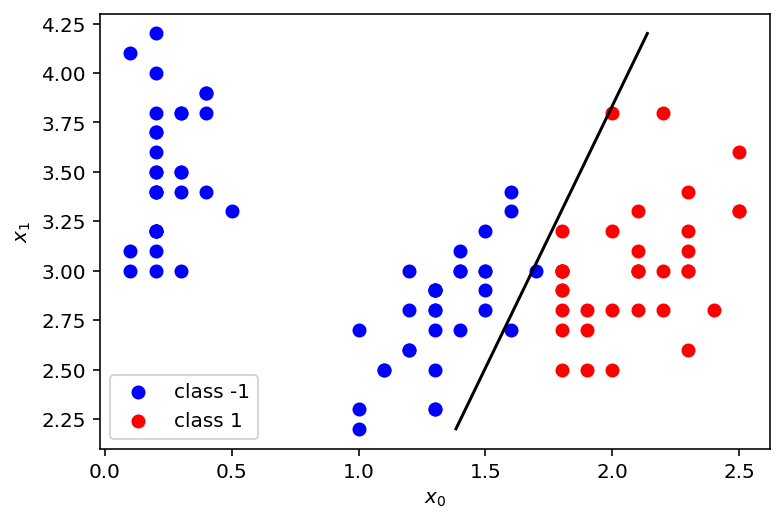

Training error: 0.020202020202020204


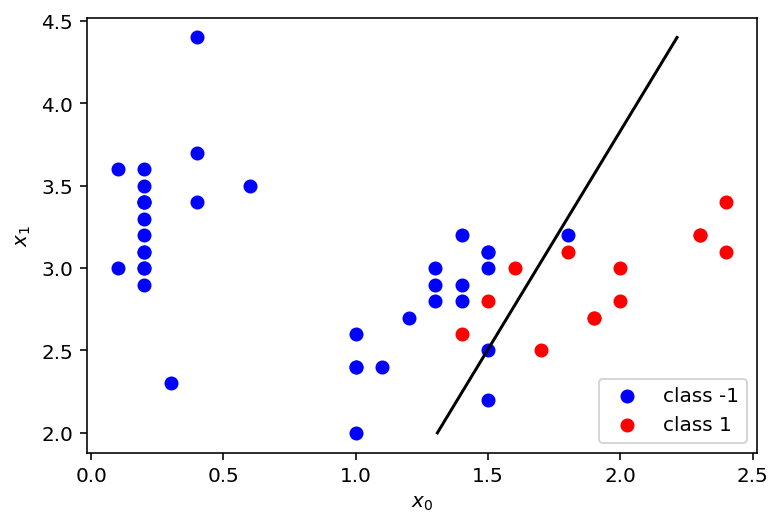

Test error: 0.12


In [211]:
# Show decision boundary, training error and test error.
print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(W[0],W[1],b))
vis(X_train, Y_train, W, b)
print('Training error: {}'.format(calc_error(X_train, Y_train, W, b)))
vis(X_test, Y_test, W, b)
print('Test error: {}'.format(calc_error(X_test, Y_test, W, b)))

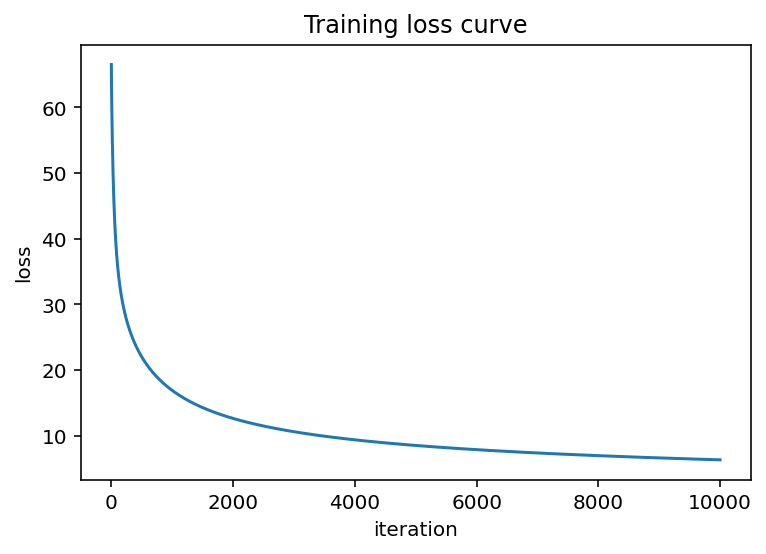

In [212]:
# Plot training loss curve.
plt.title('Training loss curve')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(losses)
plt.show()